# Spark Configuration

Spark Setting

1. Install Homebrew
2. Install OpenJDK@11 via homebrew 
```
# Install OpenJDK 11
brew install openjdk@11
```
3. Install Scala(optional)
```
# Install Scala (optional)
brew install scala
```
4. Install Python
5. Install PySpark on Mac
```
brew install apache-spark
```

* access http://localhost:4040/jobs/ from your favorite web browser to access Spark Web UI to monitor your jobs.


1. Install miniconda
2. Install Java
3. Install PySpark
4. Install FindSpark
5. Validate PySpark Installation
* Jave_home
```
bash: /usr/libexec/java_home
```
/Library/Java/JavaVirtualMachines/microsoft-11.jdk/Contents/Home

In [1]:
import findspark
findspark.init()
findspark.find()

'/Users/baixianger/opt/miniconda3/envs/sn/lib/python3.8/site-packages/pyspark'

# Why do I use spark to handle data?

1. I want some newest movie data to analysis, the `MovieLens` dataset hasn't updated for three years maybe (Released 12/2019). 
2. I tried use an API python package, called `Cinemagoer` to get data from IMDB website. The IMDB api is not stable and has some request limitation, but it can get very rich movie informations, including `box office`, `budget`, `keywords`, `plot`, `synopsis` for movies, and `birthdate`, `birthplace`, `biography`, `notes`, `trivia`. 
3. I also tried to write a webspider script powered by `beautifulsoup4` to obtain reviews for each movie.
4. The above processings are really time consuming for more than 6,000 movies 7,000 actors as well as 3,000 directors. Then I downloaded the whole official dataset from `https://datasets.imdbws.com/`, which is a big data with 9 million records, so i begin to use `spark` to get some basic information.
5. After so many trials and errors, my pipeline for processing data is a hybird of `API`, `web crawler` and `Big Data` now.

**Pros:**
1. I can build network of IMDB and Netflix, where Netflix can be seen as a subset of IMDB, or can be seen as a sampling of IMDB. I can observe the difference between those two network, and try to explain it.
2. Fresh and first hand dataset.

**Cons:**
1. Time consuming for personal computer. (Use DTU HPC 🤭)
2. Hard to congure the graphframes package in pyspark

# How to use graphframes in pyspark

**How to [+](https://graphframes.github.io/graphframes/docs/_site/index.html)**

*Graphframes only support pyspark under 3.2*

Include this package in your Spark Applications using:

```[shell]
# find the right version on the website and run the command in your shell
pyspark --packages graphframes:graphframes:0.8.2-spark3.2-s_2.12
```

**How to run on jupyter lab:**

1. Set environment variables, ```nano ~/.zshrc```
```
export PYSPARK_DRIVER_PYTHON=”jupyter”
export PYSPARK_DRIVER_PYTHON_OPTS=”notebook”
export SPARK_OPTS=” — packages graphframes:graphframes:0.8.2-spark3.2-s_2.12"
```
2. Get the jar file manually from https://spark-packages.org/package/graphframes/graphframes, check the version of your spark and scale

3. Load the jar file in the Jupyter notebook
`sc.addPyFile(‘path_to_the_jar_file’)`

    Import error:

    *https://github.com/graphframes/graphframes/issues/172*

    *https://stackoverflow.com/questions/36397136/importing-pyspark-packages*  put env variable into `load_spark-env.sh`

    Add-on:

    *https://github.com/moj-analytical-services/splink_graph* splink_graph
4. Sources:

    Graph Modeling in PySpark using GraphFrames: Part 1 *https://blog.devgenius.io/graph-modeling-in-pyspark-using-graphframes-part-1-e7cb42099182*

In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
sc=spark.sparkContext
sc.addPyFile('/Users/baixianger/opt/miniconda3/envs/sn/lib/python3.8/site-packages/pyspark/jars/graphframes-0.8.2-spark3.2-s_2.12.jar') 

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/12/03 04:12:22 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# IMDB Network

## Get Nodes and Links from IMDB

In [6]:
from pyspark.sql.functions import split, col
from pyspark.sql.types import StructType, IntegerType, StringType, FloatType

# All the titles in IMDB, which have 9,395,215 titles
title_basic = spark.read.csv("./title.basics.tsv", sep='\t', header=True)
# Selecting only movie titles, which have 627,833 titles
movie_basic = title_basic.filter(title_basic.titleType == "movie")\
                         .select('tconst', 'primaryTitle', 'startYear', 'runtimeMinutes', 'genres')
                         
# Add rating
title_rating = spark.read.csv("./title.ratings.tsv", sep='\t', header=True)
movie_basic = movie_basic.join(title_rating, movie_basic.tconst == title_rating.tconst, 'left')\
                         .drop(title_rating.tconst)

# if needed, we can split the comma separeted element into sequence.
movie_basic = movie_basic.withColumn("genres", split(col("genres"),","))\
                         .withColumn("startYear", movie_basic.startYear.cast(IntegerType()))\
                         .withColumn("runtimeMinutes", movie_basic.runtimeMinutes.cast(IntegerType()))\
                         .withColumn("averageRating", movie_basic.averageRating.cast(FloatType()))\
                         .withColumn("numVotes", movie_basic.numVotes.cast(IntegerType()))

movie_basic.show(n=3) # 627833

+---------+-----------------+---------+--------------+-------------+-------------+--------+
|   tconst|     primaryTitle|startYear|runtimeMinutes|       genres|averageRating|numVotes|
+---------+-----------------+---------+--------------+-------------+-------------+--------+
|tt1810520|       On the Sly|     2011|            77|     [Family]|          6.6|     130|
|tt1043494|  Life Inside Out|     2006|            73|[Documentary]|          6.6|      10|
|tt4830046|Shadow of Treason|     1963|            89|      [Drama]|          5.4|      34|
+---------+-----------------+---------+--------------+-------------+-------------+--------+
only showing top 3 rows



In [7]:
# change string to int
movie_basic.printSchema()

root
 |-- tconst: string (nullable = true)
 |-- primaryTitle: string (nullable = true)
 |-- startYear: integer (nullable = true)
 |-- runtimeMinutes: integer (nullable = true)
 |-- genres: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- averageRating: float (nullable = true)
 |-- numVotes: integer (nullable = true)



In [8]:
from pyspark.sql.functions import col

movie_actor_basic = spark.read.csv("./title.principals.tsv", sep='\t', header=True)\
                         .filter(col("category") == "actor")

movie_actor_basic = movie_actor_basic.join(movie_basic, movie_basic.tconst == movie_actor_basic.tconst, 'inner')\
                                     .select(movie_basic.tconst, 'nconst', 'category')
movie_actor_basic.show(n=3) # 1213746

+---------+---------+--------+
|   tconst|   nconst|category|
+---------+---------+--------+
|tt0000862|nm5289318|   actor|
|tt0000862|nm5289829|   actor|
|tt0000862|nm0386036|   actor|
+---------+---------+--------+
only showing top 3 rows



name basic 里列出的名字没有覆盖全到，movie actor pairs里的所有actor.

In [9]:
name_basic = spark.read.csv("./name.basics.tsv", sep='\t', header=True)
cond = (movie_actor_basic.nconst == name_basic.nconst)
actor_basic = movie_actor_basic.select("nconst")\
                               .distinct()\
                               .join(name_basic,  cond, 'left')\
                               .select(movie_actor_basic.nconst, "primaryName", "birthYear", "deathYear")\
                               .orderBy("birthYear")\
                               .withColumn("birthYear", name_basic.birthYear.cast(IntegerType()))\
                               .withColumn("deathYear", name_basic.deathYear.cast(IntegerType()))
actor_basic.cache()
actor_basic.show(n=3) # 425944 for inner, 426018 for left.

+----------+-----------+---------+---------+
|    nconst|primaryName|birthYear|deathYear|
+----------+-----------+---------+---------+
|nm13859265|       null|     null|     null|
|nm12467886|       null|     null|     null|
| nm1845157|       null|     null|     null|
+----------+-----------+---------+---------+
only showing top 3 rows



In [10]:
movie_basic.write.parquet("./imdb/movie_basic.parquet") 
actor_basic.write.parquet("./imdb/actor_basic.parquet") 
movie_actor_basic.write.parquet("./imdb/movie_actor_basic.parquet") 

22/12/03 04:28:25 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
22/12/03 04:28:32 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
22/12/03 04:28:34 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
22/12/03 04:28:34 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
22/12/03 04:29:20 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


## ~*Build IMDB Network using Graphframes~
**Only support basic graph function**
![img](https://spark.apache.org/docs/latest/img/graphx_logo.png)

There are some naming conventions that one needs to follow:

1. A dataframe that represents vertices should contain a column named id.
2. A dataframe that represents edges should contain columns named src and dst.

In [11]:
from pyspark.sql.functions import coalesce

# source from https://stackoverflow.com/questions/36601769/does-graphframes-api-support-creation-of-bipartite-graphs
# By now, Graphframes dose not support a bipartite graph directly, but we can build a sup dataframe by using join and full_outer to solve it.
node_basic = movie_basic.join(actor_basic, actor_basic.nconst == movie_basic.tconst, 'full_outer')\
                        .withColumn('tconst', coalesce("tconst", "nconst"))\
                        .drop('nconst')\
                        .withColumnRenamed('tconst', 'id')

In [12]:
# By now, Graphframes only support directed graph, so we revert the links and join with the oringal links
movie_actor_basic_in = movie_actor_basic.withColumnRenamed('tconst', 'src')\
                                        .withColumnRenamed('nconst', 'dst')\
                                        .select('src', 'dst') # 1213746

movie_actor_basic_out = movie_actor_basic.withColumnRenamed('nconst', 'src')\
                                         .withColumnRenamed('tconst', 'dst')\
                                         .select('src', 'dst') # 1213746
# join
link_basic = movie_actor_basic_in.union(movie_actor_basic_out)
# link_basic.count() # 1213746 * 2 = 2427492

In [13]:
node_basic.write.parquet("./imdb/node_basic.parquet") 
link_basic.write.parquet("./imdb/link_basic.parquet") 

22/12/03 04:29:39 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
22/12/03 04:30:24 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
22/12/03 04:30:32 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


In [14]:
from graphframes import *

node = spark.read.parquet("./imdb/node_basic.parquet")
link = spark.read.parquet("./imdb/link_basic.parquet")

g = GraphFrame(node, link)

In [15]:
g.vertices.show(n=5)
N = g.vertices.count()
N

+---------+------------+---------+--------------+------+-------------+--------+----------------+---------+---------+
|       id|primaryTitle|startYear|runtimeMinutes|genres|averageRating|numVotes|     primaryName|birthYear|deathYear|
+---------+------------+---------+--------------+------+-------------+--------+----------------+---------+---------+
|nm0000009|        null|     null|          null|  null|         null|    null|  Richard Burton|     1925|     1984|
|nm0000019|        null|     null|          null|  null|         null|    null|Federico Fellini|     1920|     1993|
|nm0000024|        null|     null|          null|  null|         null|    null|    John Gielgud|     1904|     2000|
|nm0000032|        null|     null|          null|  null|         null|    null| Charlton Heston|     1923|     2008|
|nm0000036|        null|     null|          null|  null|         null|    null|   Buster Keaton|     1895|     1966|
+---------+------------+---------+--------------+------+--------

1053851

In [16]:
g.edges.show(n=5)
g.edges.count()

+---------+---------+
|      src|      dst|
+---------+---------+
|nm0609814|tt0000886|
|nm0064953|tt0001116|
|nm0085066|tt0001116|
|nm0169878|tt0001116|
|nm0299757|tt0001116|
+---------+---------+
only showing top 5 rows



2427492

In [17]:
vertexInDegrees = g.inDegrees
vertexInDegrees.show(n=5)

+---------+--------+
|       id|inDegree|
+---------+--------+
|nm0733443|      26|
|nm0709856|      63|
|nm0436013|       4|
|nm0005706|       1|
|nm0582544|      13|
+---------+--------+
only showing top 5 rows



In [18]:
degree_dist = vertexInDegrees.groupBy('inDegree').count()
degree_dist.show(n=5)

+--------+-----+
|inDegree|count|
+--------+-----+
|     148|    4|
|      31|  232|
|     137|    5|
|      85|   23|
|      65|   32|
+--------+-----+
only showing top 5 rows



In [19]:
# Convert PySpark Dataframe to Pandas DataFrame
import numpy as np
import pandas as pd
import powerlaw
import matplotlib.pyplot as plt
degree_list = vertexInDegrees.select('inDegree').toPandas().astype('int').values[:, 0]
degree_dist_pandas = degree_dist.toPandas().astype('int').values

In [20]:
from pyspark.sql.functions import col
mg = g.filterVertices(col('primaryName').isNull())

In [21]:
mgDegrees = mg.inDegrees
mgDegrees.show(n=5)

+----------+--------+
|        id|inDegree|
+----------+--------+
| nm4804573|       1|
|nm11406401|       1|
|nm13833007|       1|
|nm12458265|       2|
|nm13859428|       5|
+----------+--------+
only showing top 5 rows



Calculating best minimal value for power law fit


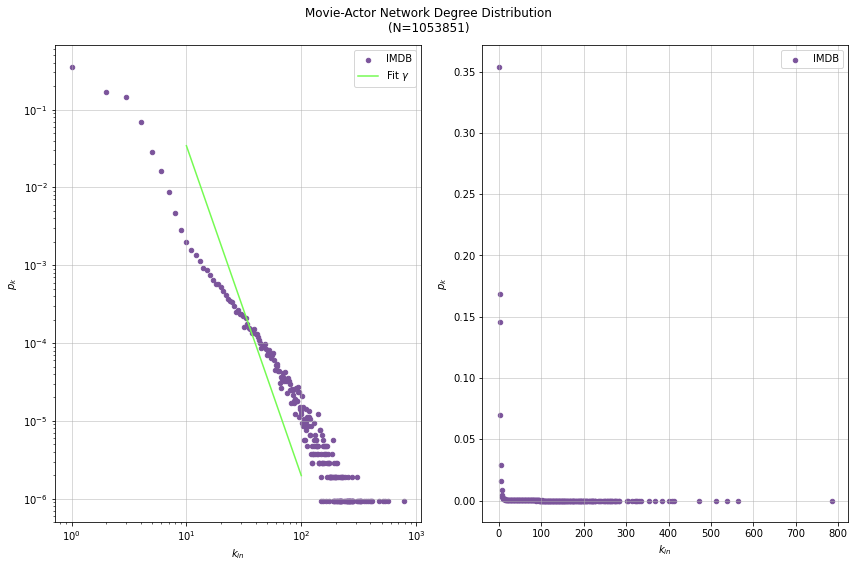

In [22]:
pl = powerlaw.Fit(degree_list, discrete=True)
gamma = pl.alpha
kmin = pl.xmin
xs = np.linspace(10, 100, 100)
ys = (gamma - 1) * 5 ** (gamma -1) * xs ** (-gamma)
gamma, kmin # (4.270224347693521, 135.0)

c = ['#7b549b', '#75fb52', '#e8964a', '#ae8fbd']
tags = ['IMDB']
def draw_degree_distribution(dist, N, title, tag, color='#7b549b', xs=xs, ys=ys, c1='#75fb52'):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,8))
    ax1.scatter(dist[:, 0], dist[:, 1] / N, s=20, c=color, label=tag)
    ax1.plot(xs, ys, '-', c=c1, label='Fit $\gamma$')
    ax2.scatter(dist[:, 0], dist[:, 1] / N, s=20, c=color, label=tag)
    ax1.set_xlabel('$k_{in}$')
    ax1.set_ylabel('$p_k$')
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax1.grid(alpha=0.6)
    ax1.legend()
    ax2.set_xlabel('$k_{in}$')
    ax2.set_ylabel('$p_k$')
    ax2.grid(alpha=0.6)
    ax2.legend()
    plt.suptitle(f'{title} Degree Distribution\n(N={N})')
    plt.tight_layout()
    plt.show()
    
draw_degree_distribution(degree_dist_pandas, N, 'Movie-Actor Network', 'IMDB')

In [23]:
g.vertices.filter("numVotes > 2000000").show()

+---------+--------------------+---------+--------------+--------------------+-------------+--------+-----------+---------+---------+
|       id|        primaryTitle|startYear|runtimeMinutes|              genres|averageRating|numVotes|primaryName|birthYear|deathYear|
+---------+--------------------+---------+--------------+--------------------+-------------+--------+-----------+---------+---------+
|tt1375666|           Inception|     2010|           148|[Action, Adventur...|          8.8| 2336620|       null|     null|     null|
|tt0109830|        Forrest Gump|     1994|           142|    [Drama, Romance]|          8.8| 2064666|       null|     null|     null|
|tt0110912|        Pulp Fiction|     1994|           154|      [Crime, Drama]|          8.9| 2038992|       null|     null|     null|
|tt0137523|          Fight Club|     1999|           139|             [Drama]|          8.8| 2109298|       null|     null|     null|
|tt0468569|     The Dark Knight|     2008|           152|[Acti

# Netflix Network

## Get Nodes and Links

In [24]:
# load checkpoints
movie_basic = spark.read.parquet("./imdb/movie_basic.parquet") 
actor_basic = spark.read.parquet("./imdb/actor_basic.parquet")  
movie_actor_basic = spark.read.parquet("./imdb/movie_actor_basic.parquet") 

### Movie List in Netflix

In [25]:
from pyspark.sql.functions import split, col, regexp_extract
from pyspark.sql.types import StructType, IntegerType, StringType

# Read netflix titles, which have 6,131 movie titles
netflix_basic = spark.read.csv(r"./netflix.titles.csv", header=True).filter(col("type") == "Movie")\
                     .withColumn("duration", regexp_extract(col("duration"), "(\d+)", 1))

# Join condition for two dataframe
cond = (netflix_basic.title == movie_basic.primaryTitle)\
       & (netflix_basic.release_year == movie_basic.startYear)

# Join
movie = netflix_basic.join(movie_basic, cond, 'inner')\
                     .select('tconst', 'primaryTitle', 'startYear', 'runtimeMinutes', 
                             'genres', 'country', 'description', 'averageRating', 'numVotes')\
                     .orderBy('startYear')\
                     .withColumn("country", split(col("country"),", "))
movie.cache()
movie.show(n=5)
movie.count() # 4129

+---------+--------------------+---------+--------------+--------------------+--------------------+--------------------+-------------+--------+
|   tconst|        primaryTitle|startYear|runtimeMinutes|              genres|             country|         description|averageRating|numVotes|
+---------+--------------------+---------+--------------+--------------------+--------------------+--------------------+-------------+--------+
|tt0037404|    Tunisian Victory|     1944|            75|  [Documentary, War]|[United States, U...|British and Ameri...|          6.6|     624|
|tt0185405|Know Your Enemy -...|     1945|            63|[Documentary, His...|     [United States]|Though culturally...|          6.0|     806|
|tt0044429|     The Blazing Sun|     1954|           105|[Crime, Drama, Ro...|             [Egypt]|Competition betwe...|          7.2|    1343|
|tt0047673|     White Christmas|     1954|           120|[Comedy, Musical,...|     [United States]|Two war buddies f...|          7.5|  

4129

In [26]:
movie.printSchema()

root
 |-- tconst: string (nullable = true)
 |-- primaryTitle: string (nullable = true)
 |-- startYear: integer (nullable = true)
 |-- runtimeMinutes: integer (nullable = true)
 |-- genres: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- country: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- description: string (nullable = true)
 |-- averageRating: float (nullable = true)
 |-- numVotes: integer (nullable = true)



### Movie-Actor Links

In [27]:
cond = (movie.tconst == movie_actor_basic.tconst)
movie_actor = movie_actor_basic.join(movie, cond, 'inner')\
                               .select(movie.tconst, 'nconst')
movie_actor.show(n=3)
movie_actor.count()

+---------+---------+
|   tconst|   nconst|
+---------+---------+
|tt0046292|nm0001120|
|tt0046292|nm0885203|
|tt0056193|nm0000051|
+---------+---------+
only showing top 3 rows



9239

### Actor List in Netflix

In [28]:
cond = (movie_actor.nconst == actor_basic.nconst)
actor = movie_actor.select("nconst")\
                   .distinct()\
                   .join(actor_basic, cond, 'left')\
                   .select(movie_actor.nconst, actor_basic.primaryName, actor_basic.birthYear, actor_basic.deathYear)\
                   .orderBy("birthYear")
actor.cache()
actor.show(n=3)
actor.count() # 6021

+----------+-------------+---------+---------+
|    nconst|  primaryName|birthYear|deathYear|
+----------+-------------+---------+---------+
| nm0653658| Jen Kuo Sung|     null|     null|
| nm4729449|   Rajat Kaul|     null|     null|
|nm13250516|Yazeed Faruja|     null|     null|
+----------+-------------+---------+---------+
only showing top 3 rows



6021

In [29]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StructType, IntegerType, StringType

def movieCount(x):
    # count the movies a given actor played
    if x == None: 
        return '0'
    else:
        split = x.split(',')
        return str(len(split))
    
udf_movieCount = udf(movieCount, StringType())

# # It turn out that IMDB.com only lists four movies an actor played, so we do not need do this step.
# actor = actor.withColumn("movieCount", udf_movieCount("knownForTitles"))
# actor.withColumn("movieCount",actor.movieCount.cast(IntegerType()))\
#      .groupby().max('movieCount').first().asDict()['max(movieCount)']  # 4

## Save As Parquet

In [30]:
# Examples
# df.write.parquet("/tmp/out/people.parquet") 
# parDF1=spark.read.parquet("/temp/out/people.parquet")

movie.write.parquet("./netflix/movie.parquet") 
actor.write.parquet("./netflix/actor.parquet") 
movie_actor.write.parquet("./netflix/movie_actor.parquet") 

22/12/03 04:31:13 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
22/12/03 04:31:13 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
22/12/03 04:31:13 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
22/12/03 04:31:13 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
22/12/03 04:31:14 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
22/12/03 04:31:14 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
22/12/03 04:31:14 WARN MemoryManager: Total allocation exceeds 95.00% 